In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
from scipy import stats
from scipy.stats import pearsonr

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from xgboost.sklearn import XGBClassifier

import warnings
import missingno as msno
warnings.filterwarnings('ignore')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
df_age_gender=pd.read_csv('/mnt/e/College/Sem 5/ML_Project/airbnb-new-user/age_gender_bkts.csv')
df_countries=pd.read_csv('/mnt/e/College/Sem 5/ML_Project/airbnb-new-user/countries.csv')
df_sample=pd.read_csv('/mnt/e/College/Sem 5/ML_Project/airbnb-new-user/sample_submission_NDGC_3.csv')
df_session=pd.read_csv('/mnt/e/College/Sem 5/ML_Project/airbnb-new-user/sessions.csv')
df_test=pd.read_csv('/mnt/e/College/Sem 5/ML_Project/airbnb-new-user/test.csv',parse_dates=['timestamp_first_active','date_account_created','date_first_booking'])
df_train=pd.read_csv('/mnt/e/College/Sem 5/ML_Project/airbnb-new-user/train.csv',parse_dates=['timestamp_first_active','date_account_created','date_first_booking'])

In [3]:
np.random.seed(0)

In [4]:
df_test.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,f3g7ae12j0,2014-04-01,2014-04-01 00:01:02,NaT,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari
1,ks0uq0sd8x,2014-04-01,2014-04-01 00:03:19,2014-04-01,MALE,22.0,facebook,12,en,api,other,untracked,iOS,iPhone,Mobile Safari
2,8w236a1unv,2014-04-01,2014-04-01 00:03:43,NaT,MALE,36.0,basic,0,en,sem-non-brand,google,omg,Web,Mac Desktop,Safari
3,vd221xgcu6,2014-04-01,2014-04-01 00:05:19,2014-04-01,MALE,52.0,basic,0,en,sem-brand,google,omg,Web,Windows Desktop,Chrome
4,bt5x8x87wu,2014-04-01,2014-04-01 00:07:30,2014-04-01,MALE,51.0,basic,0,en,seo,google,linked,Web,Windows Desktop,Chrome


In [5]:
df_train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaT,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,NaT,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [6]:
df_test.describe()

,age,signup_flow
count,24093.000000,43314.000000
mean,39.739426,5.922658
std,86.531170,10.287322
min,1.000000,0.000000
25%,27.000000,0.000000
50%,32.000000,0.000000
75%,41.000000,12.000000
max,2014.000000,25.000000


In [7]:
df_train.describe()

,age,signup_flow
count,101368.000000,170137.000000
mean,52.028224,2.591400
std,167.877942,6.632642
min,1.000000,0.000000
25%,29.000000,0.000000
50%,34.000000,0.000000
75%,43.000000,0.000000
max,2014.000000,25.000000


In [8]:
piv_train = df_train.shape[0]

In [9]:

country_label = df_train.country_destination.values
id_test = df_test.id
df_train2=df_train.drop(['country_destination'], axis = 1)

#Concatenating train and test data for EDA
df_all = pd.concat((df_train2, df_test), axis = 0, ignore_index= True)


In [10]:
df_all.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaT,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,NaT,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome


In [11]:
print(df_all.isnull().sum())

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
dtype: int64


In [12]:
df_session.isnull().sum()

user_id            34496
action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
dtype: int64

## Preprocesing the combined datasets

In [13]:
print(df_all.isnull().sum())

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
dtype: int64


In [14]:
df_all = df_all.fillna(-1)

In [15]:
df_all.gender.replace('-unknown-', np.nan, inplace=True)
df_all.first_browser.replace('-unknown-', np.nan, inplace=True)

In [16]:
# df_all.loc[df_all.age > 100, 'age'] = np.nan
# df_all.loc[df_all.age < 18, 'age'] = np.nan

av = df_all.age.values
df_all['age'] = np.where(np.logical_or(av<14, av>100), -1, av)

df_all.loc[df_all.age.isnull(),'age']=df_all.age.mean()

In [17]:
av = df_all.age.values
df_all['age'] = np.where(np.logical_and(av>1919, av<1995), 2015-av, av)
df_all['age'] = np.where(np.logical_or(av<14, av>100), -1, av)

In [18]:
for i in df_all.columns:
    null_check = df_all[i].isnull().sum()
    if null_check != 0:
        print(i + " has {} null values.".format(null_check))
        print()

gender has 95688 null values.

first_browser has 27266 null values.



In [19]:
df_all.describe()

,age,signup_flow
count,213451.000000,213451.000000
mean,20.653677,3.267387
std,20.572020,7.637707
min,-1.000000,0.000000
25%,-1.000000,0.000000
50%,26.000000,0.000000
75%,35.000000,0.000000
max,100.000000,25.000000


## Feature Engineering

In [20]:
print(df_session.isnull().sum())

user_id            34496
action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
dtype: int64


#### sessions_count

In [21]:
# #Count the number of sessions of a user
# df=df_session.user_id.value_counts()
# df=df.to_frame()
# df=df.rename(columns={'user_id' : 'sessions_count'})
# df['id']=df.index

# df_all=pd.merge(df_all,df,how = 'left',on = ['id'])
# df_all.sessions_count.fillna(-1, inplace = True)
# df_all.sessions_count = df_all.sessions_count.astype(int)

#### average_seconds

In [22]:
#Total time user spends on the AirBnB website
average_seconds = df_session.groupby('user_id')['secs_elapsed'].mean()

df_all['average_seconds'] = df_all['id'].apply(lambda x: average_seconds[x] if x in average_seconds else 0)


#### long_sessions_count

In [23]:
long_sessions_count= df_session[df_session['secs_elapsed'] >= 1800].groupby('user_id')['action'].count()
df_all['long_sessions_count'] = df_all['id'].apply(lambda x: long_sessions_count[x] if x in long_sessions_count else 0)


#### date_account_created & timestamp_first_active

In [24]:
df_all.date_account_created = pd.to_datetime(df_all.date_account_created)
df_all.timestamp_first_active = pd.to_datetime(df_all.timestamp_first_active)

# Splitting date time data for date account created
df_all['dac_year'] = df_all.date_account_created.dt.year
df_all['dac_month'] = df_all.date_account_created.dt.month
df_all['dac_day'] = df_all.date_account_created.dt.day

# Splitting date time data for time first active
df_all['tfa_year'] = df_all.timestamp_first_active.dt.year
df_all['tfa_month'] = df_all.timestamp_first_active.dt.month
df_all['tfa_day'] = df_all.timestamp_first_active.dt.day

df_all = df_all.drop(['date_account_created'], axis=1)
df_all = df_all.drop(['timestamp_first_active'], axis=1)
df_all = df_all.drop(['id', 'date_first_booking'], axis=1)


df_all.fillna(method='pad').head()# Final step to fill in all the reaming NaN values

,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,average_seconds,long_sessions_count,dac_year,dac_month,dac_day,tfa_year,tfa_month,tfa_day
0,NaN,-1.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,0.0,0,2010,6,28,2009,3,19
1,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,0.0,0,2011,5,25,2009,5,23
2,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,0.0,0,2010,9,28,2009,6,9
3,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,0.0,0,2011,12,5,2009,10,31
4,FEMALE,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,0.0,0,2010,9,14,2009,12,8


## One-Hot Encoding of the CF

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler




categorical_features = ['affiliate_channel','affiliate_provider','first_affiliate_tracked','first_browser','first_device_type','gender','language','signup_app','signup_method','signup_flow']
for categorical_feature in categorical_features:
        df_all_dummy = pd.get_dummies(df_all[categorical_feature], prefix=categorical_feature)
        df_all = df_all.drop([categorical_feature], axis=1)
        df_all = pd.concat((df_all, df_all_dummy), axis=1)

    
    






## Train-Test split

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
# np.isnan(X_train)

In [28]:
# np.nan_to_num(X_train)

#To avoid the NaN values while running the Logistic Regression model
# X_train.fillna(X_train.mean(), inplace=True)


In [29]:
vals = df_all.values
X_train= df_all.iloc[:len(df_train), :]
X_test= df_all.iloc[len(df_train):, :]
# X_train= vals[:piv_train]
le = LabelEncoder()
y = le.fit_transform(country_label)   
# X_test = vals[piv_train:]

In [30]:
X_train.fillna(X_train.mean(), inplace=True)
np.nan_to_num(X_train)

array([[-1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.80000000e+01,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 5.60000000e+01,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 3.20000000e+01,  3.98482381e+04,  2.70000000e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.00000000e+01,  9.81312632e+03,  3.40000000e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.00000000e+00,  6.75113725e+03,  5.30000000e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [31]:

xtrain, xtest, ytrain, ytest = train_test_split(X_train, y, test_size = 0.25, random_state = 804)

In [32]:
print(xtrain.shape)
print(ytrain.shape)
print(X_train.shape)
print(y.shape)

(127602, 155)
(127602,)
(170137, 155)
(170137,)


In [33]:


#To avoid the NaN values while running the Logistic Regression model
X_train.fillna(X_train.mean(), inplace=True)
np.nan_to_num(X_train)

array([[-1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.80000000e+01,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 5.60000000e+01,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 3.20000000e+01,  3.98482381e+04,  2.70000000e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.00000000e+01,  9.81312632e+03,  3.40000000e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.00000000e+00,  6.75113725e+03,  5.30000000e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [34]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(xtrain, ytrain)
pred_log=logreg.predict(xtest)
from sklearn.metrics import accuracy_score
print(accuracy_score(ytest, pred_log))

#NDCG 

0.5725167509110145


In [35]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_depth=20, n_estimators=100)
rfc.fit(xtrain , ytrain)
pred = rfc.predict(xtest)
print(accuracy_score(ytest, pred))

0.6196073821558716


In [ ]:
#xgb=XGBClassifier()
#params={
#    'max_depth' :[1,10],
#    'learning_rate' : [0.1,1],
#    'n_estimators' : [10,50],
#    'objective':['binary:logistic','multi:softprob'],
#    'subsample' : [0,1],
#    'colsample_bytree' : [0,1]
#}
#grid_xgb = GridSearchCV(estimator = xgb, param_grid = params,scoring = 'accuracy', cv =5, verbose =1, n_jobs = -1)

#grid_xgb.fit(X_train,y)

In [ ]:
#print(grid_xgb.best_estimator_)

In [ ]:
#print(grid_xgb.score(X_train,y))

In [36]:
from xgboost.sklearn import XGBClassifier
xgb = XGBClassifier(max_depth=4, learning_rate=0.03, n_estimators=100,
                    objective='multi:softprob', subsample=0.6, colsample_bytree=0.6, seed=40)
xgb.fit(xtrain , ytrain)
pred = xgb.predict(xtest) 
print(accuracy_score(ytest, pred))

0.6216997766545198


### As XGBClassifier is clearly more accurate we'll use the XGBModel to train

In [37]:
X_train

,age,average_seconds,long_sessions_count,dac_year,dac_month,dac_day,tfa_year,tfa_month,tfa_day,affiliate_channel_api,...,signup_flow_8,signup_flow_10,signup_flow_12,signup_flow_15,signup_flow_16,signup_flow_20,signup_flow_21,signup_flow_23,signup_flow_24,signup_flow_25
0,-1.0,0.000000,0,2010,6,28,2009,3,19,0,...,0,0,0,0,0,0,0,0,0,0
1,38.0,0.000000,0,2011,5,25,2009,5,23,0,...,0,0,0,0,0,0,0,0,0,0
2,56.0,0.000000,0,2010,9,28,2009,6,9,0,...,0,0,0,0,0,0,0,0,0,0
3,42.0,0.000000,0,2011,12,5,2009,10,31,0,...,0,0,0,0,0,0,0,0,0,0
4,41.0,0.000000,0,2010,9,14,2009,12,8,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170132,-1.0,47654.454545,41,2014,3,31,2014,3,31,0,...,0,0,0,0,0,0,0,0,0,0
170133,23.0,17782.153846,37,2014,3,31,2014,3,31,0,...,0,0,0,0,0,0,0,0,0,0
170134,32.0,39848.238095,27,2014,3,31,2014,3,31,0,...,0,0,0,0,0,0,0,0,0,0
170135,30.0,9813.126316,34,2014,3,31,2014,3,31,0,...,0,0,0,0,0,0,0,0,0,0


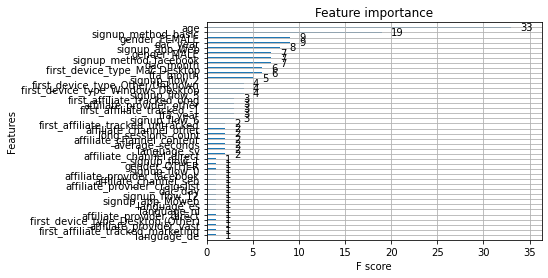

In [38]:
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
xgb=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=1, max_delta_step=0, max_depth=2,
              min_child_weight=1,monotone_constraints='()',
              n_estimators=5, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None,seed=0)

 

xgb.fit(X_train,y)

plot_importance(xgb)
pyplot.show()


In [39]:
from sklearn.metrics import accuracy_score
pred = xgb.predict(xtest)
print(accuracy_score(ytest, pred))

0.6180792288703421


In [40]:
y_pred=xgb.predict_proba(X_test)

In [41]:
# #We cons
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 5
    cts += le.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()

#Generate submiss


In [42]:
cts

['NDF',
 'US',
 'other',
 'FR',
 'IT',
 'NDF',
 'US',
 'other',
 'FR',
 'ES',
 'US',
 'NDF',
 'other',
 'FR',
 'GB',
 'US',
 'NDF',
 'other',
 'FR',
 'GB',
 'US',
 'NDF',
 'other',
 'FR',
 'GB',
 'NDF',
 'US',
 'other',
 'FR',
 'IT',
 'NDF',
 'US',
 'other',
 'FR',
 'IT',
 'NDF',
 'US',
 'other',
 'FR',
 'IT',
 'US',
 'NDF',
 'other',
 'FR',
 'IT',
 'NDF',
 'US',
 'other',
 'IT',
 'FR',
 'NDF',
 'US',
 'other',
 'FR',
 'IT',
 'NDF',
 'US',
 'other',
 'FR',
 'ES',
 'US',
 'NDF',
 'other',
 'FR',
 'IT',
 'US',
 'NDF',
 'other',
 'FR',
 'IT',
 'NDF',
 'US',
 'other',
 'IT',
 'FR',
 'US',
 'NDF',
 'other',
 'FR',
 'GB',
 'NDF',
 'US',
 'other',
 'IT',
 'FR',
 'NDF',
 'US',
 'other',
 'FR',
 'IT',
 'NDF',
 'US',
 'other',
 'FR',
 'IT',
 'NDF',
 'US',
 'other',
 'FR',
 'IT',
 'NDF',
 'US',
 'other',
 'FR',
 'ES',
 'US',
 'NDF',
 'other',
 'FR',
 'IT',
 'NDF',
 'US',
 'other',
 'FR',
 'IT',
 'NDF',
 'US',
 'other',
 'FR',
 'ES',
 'US',
 'NDF',
 'other',
 'FR',
 'IT',
 'NDF',
 'US',
 'other',


In [43]:
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country_destination'])
sub.to_csv('submission.csv',index=False)